<img style="float: right; width: 200px;"
    src="http://www.polymtl.ca/profiles/portail/themes/custom/bueno/logo.png">
<h1>hyperNN : Neural network hyperparameter optimization</h1>
<h3>Pierre Hulot & Antoine Prouvost</h3>
<h3>INF8225 - Artificial Intelligence</h3>

In [ ]:
import json, plots
import numpy as np

## Abstract

Neural networks are very popular nowadays, with a lot of libraries offering very efficient way of using them. Many problems are solvable using a neural network, but finding the right one, the more efficient, the more accurate is very complex and time consuming. Finding the optimal parameters of a neural network can be difficult. People are used to optmise them by hand, using their knowledge on neural networks. The effort required to find an optimal or quasi optimal configuration is so high that people usually use non-optmized netwoks. In this report we compare a few solutions proposed to optimize these parameters. We applyed the solutions on the dataset MNIST [[6](#6)].

Our case study undergo the following steps:
1. [The problem to optimize](#1.-The-problem-to-optimize) where we describe the what is the learning problem and its hyperparameters,
2. [Random search](#2.-hyperRand:-Random-search) where we explore a basic random search for reference,
3. [NN designing NN](#3.-hyperLearn:-NN-desning-NN) where we implement a neural network to predict the set of hyperparameters to use [[9](#9)],
4. [MADS algorithm](#4.-hyperMads:-MADS-algorithm) where we apply the MADS algorithm [[7](#7)] for blackbox optimization to the problem using OPAL [[8](#8)],
5. [Bayesian optimization](#5.-hyperBayes:-Bayesian-optimisation) where apply bayesian optimization [[10](#10)] to the training,
6. [Joint appoarch](#6.-Joint-appoarch) where we propose mixed approches to tke advantage of the strengh of all the different algorithms.

## 1. The problem to optimize

### The Dataset

For this project we used the well known dataset MNIST [[6](#6)]. The dataset is composed by 80 000 classified images reprensenting the numbers from 0 to 9. 
The training set is composed of 60 000 images, the test set and the validation set 10 000. We do not use any augmentation.

### The Model

We choose to implement the model using Keras [[3](#3)]. We used both tensorflow [[2](#2)] and Theano [[1](#1)] as the underlying layer.<br>
The basic model is a logistic regression with 784 inputs and 10 outputs using as loss the categorical crossentropy and as optimizer a SGD. 
We choose to fix the __number of epochs to 100__ and the __batch size to 200__. This choice was made to simplify the problem and to impose the network to find a solution in a reasonable time.<br>

All remaning parameters are used for the optimisation.<br>

One MNIST training took 1-2 minutes on our computers.<br>

### Choice of hyperparameters

We choose for this project to optimise the network on the following parameters with a stochastic gradient descent optimisation:
- The __number of layers__ : from 0 to 3
- The __number of neurons per layer__ : from 0 to 500
- The __learning rate__ : from 0 to 1
- The __L1 regularisation__ coefficient : from 0 to 1
- The __L2 regularisation__ coefficient : from 0 to 1
- The __momentum__ (wheight of previous gradient in SGD): from 0 to 1
- The __decay__ for the learning rate : from 0 to 1
- The __nesterov__ method for calculating momentums : true or false
- The __activation__ function of all hidden layers : tanh, sigmoid or relu

The number of layers and neurons is a strict policy as it controls the capacity of the model. However, for the other ranges, this is more of a general guideline. There are here to guide the algorithm toward "relevant values". When an algorithm would not behave well close to zero or with too large values, we would ajust them a little.
This is a tradeoff between the maximum accuracy possible and the convergence of the algorithm.

### Comparing models

The measure for one set of hyperparameters is the __validation accuracy__ after the training of the full training set (100 epochs).

For a pure theorical approch, we would need to run the an algorithm on a fixed number of training on MNIST (e.g. 200) multiple times to account for the probabilistic perspective of the algorithm.
We would also need to repeat this operation on a number of problem different than MNIST. We clearly do not have this kind of computing power.

Running a specific algorithm also need to adjust a couple of parameters (hopefully less than training MNIST), or even small redefinitions of the problem as stated previously. This kind of intervention is hard to account for on a theorical level.

Therefore, we will compare the different algorithms from the perspective of an individual trying to optimize the training of his neural network. The individual can make some obvious adjustments but expects the optimisation algorithm to do the heavy lifting.

## 2. hyperRand: Random search

The most natural idea after bruteforce is to explore a random search. Any solution comparing worse to this solution cannot be retained as a good solution.
We used the following marginal probabilty distribution to sample for our experiments:
- The __number of layers__ is __fixed__ to 2
- The __number of neurons per layer__ is sampled from a __poisson__ distribution of parameter 200
- The __learning rate__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __L1 regularisation__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __L2 regularisation__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __momentum__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __decay__ is sampled from a __log normal__ distribution with parameters -2 and 3
- The __nesterov__ is sample from a __uniform__ distribution
- The __activation__ is sample from a __uniform__ distribution

The number of layer has been fixed to 2 layers to compare better with [hyperMads](#4.-hyperMads:-MADS-algorithm) and hyper that we didn't have time to run on more than three layers [hyperBayes](#5.-hyperBayes:-Bayesian-optimisation). The conclusion would not change thought.

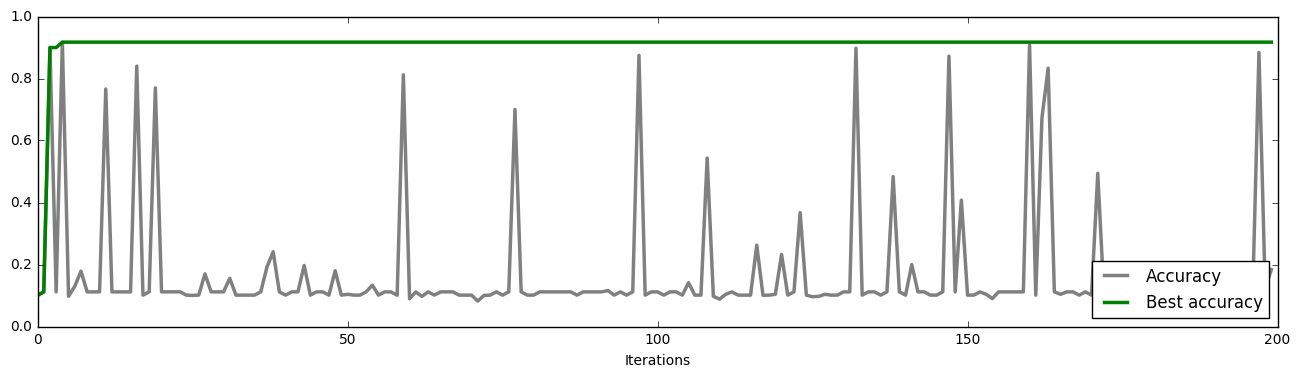

In [2]:
accRand = np.array(map(lambda j: j["Accuracy"],
                       json.load(open("results/hyperRand.json", "r"))))
plots.accuracy(accRand)

In [3]:
print("Best accuracy: {}".format(accRand.max()))
print("Number of solutions better than 80%: {}".format(np.sum(accRand >= .8)))

Best accuracy: 0.9173
Number of solutions better than 80%: 10


With only ten solutions better than 80%, and a maximum accuracy of 91.73%, the random search is a __bad algorithm__ for finding good optimal solutions.
One could arguee that the solutions found could be used to initialize another algorithm but all other algorithm already have their own way of generating and exploiting randomness.

In a way, the results really depends on the probabilistic distributions given for the parameters. An extreme case would be the a distribution with little to no variance around an optimal solution. This distribution would perform well but require a dramatic amount of knowledge from the indivual running the algorithm.

The strengths of this algorithm is that it's easy to set up and easy to parallelize (no synchronizing steps).

## 3. hyperLearn: NN desning NN

For this approach we've re-implemented the solution proposed by [[9](#9)].

### Approach : 

The idea of NN designing NN is to learn a neural network that tries to predict the performance of a Network givens its parameters. The complicated point of this approach is to generate some points on which the neural network can learn, then to refine the neural network on interessant zones to find the optimal solution. The sampling of training points is essential.

### The algorithm

Sample some random hyperparameters and train MNIST on them
train the neural network (RSM)
```python
a = 1e-4
while (n_iteration < max_iter):
    sample a random parameter
    predict its performance p
    if (p> max_performance):
        with probability (1-a):
            train_MNIST
            add result in RSM training set
            train the RSM
            update max_performance if necessary
        else do nothing
    else :
        with probability a
            train_MNIST
            add result in RSM training set
            train the RSM
            update max_performance if necessary
        else do nothing
return the best configuration
```

### The sampling

The previous algorithm is very dependant on sampling hyperparameters to test. The sampling method is a variation of Metropolis–Hastings algorithm. The first sample are random, the following are sampled with a gaussian distribution around the previous one. This method enable a local search around the optimal solution found, but also allows the exploration of the rest of the search space. 

We've beginned using when possible continous hyperparameters values. But this approach was stuck is a local minima and was not able to explore the entire space to find a good solution. This bad result is understandable because of the meaning of the values : a learning rate of 0.1 is very similar to a leaning rate of 0.13, but a learning rate of 0.001 is quite different of a learning rate of 0.031. The gaussian distribution doesn't make any difference between these two examples. Then we followed what was done in the article and we discretized the search space. This way we were able to counter the previous problem, but we've lost in the precision of the optained solution. <br>
Here are the possible values of the parameters : 

```python
values = np.array([
    [0, 1, 2, 3],  #n_couches
    range(10, 500, 10), range(10, 500, 10), range(10, 500, 10),  #couches
    [0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #learning rate
    [0.000001,0.00001,0.0001,0.001,0.01,0.1],  #reg_l1
    [0.000001,0.00001,0.0001,0.001,0.01,0.1],  #reg_l2
    [0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #moment
    [.0,0.001, 0.002, 0.004, 0.008, 0.016, 0.03, 0.06, 0.012, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8],  #decay
    [0,1],  #nesterov
    [0, 1, 2]  #activation
])
```

### Results

In [17]:
accNN = np.load('../hyperLearn/hist_res.npy')
max_acc = np.load('../hyperLearn/hist_macc.npy')
plots.accuracy(accNN)

NameError: name 'xrange' is not defined

## 4. hyperMads: MADS algorithm

The MADS algorithm [[7](#7)] stands for _Mesh Adaptive Direct Search_. It's an algorithm designed for black box optimization, that is to say an algorithm to look for the minimum of a function on which we have little information.
The function is hard to compute (can be days), may not be smooth, and may even fail to compute. The algorithm use an adaptive mesh to search the solution space.

We use the NOMAD and OPAL [[4](#4)][[8](#8)] software build at [GERAD](www.gerad.ca) to look for solutions. The following choices were made:
* We did not manage to use the categorical variables, although supported by the software, and decided to set
    ```python
        {"activation": "relu",
         "nesterov":   True}
    ```
* The other parameters needed a default value, we gave arbirarily the values
    ```python
        {"learnnig_rate": 1e-3,
         "reg_l1":        1e-4,
         "reg_l2":        1e-4,
         "moment":        1e-2,
         "decay":         1e-6,
         "noeuds":        [200, 200, 0]  # neurons
        }
    ```
    Note that the number of neurons on the third hidden layer is zero as we wanted to give a default with two layers (middle between one and three).

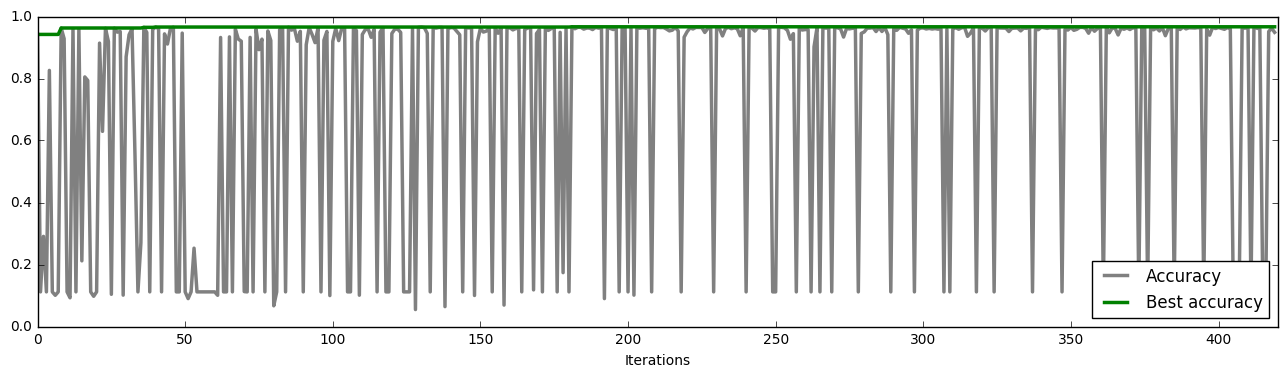

In [4]:
mads = json.load(open("results/hyperMads.json", "r"))
accMads = np.array(map(lambda j: j["Accuracy"], mads))
plots.accuracy(accMads)

In [5]:
print("Best accuracy: {} at iteration {}".format(accMads.max(), accMads.argmax()))
print("Number of solutions better than 90%: {}".format(np.sum(accMads >= .9)))
print("Accuracy at iteration 9: {}".format(accMads[8]))

Best accuracy: 0.9668 at iteration 181
Number of solutions better than 90%: 311
Accuracy at iteration 9: 0.9629


The algorithm quickly found a good solution (96.29% at iteration 9), but we can notive that it was lucky on it first guess (94,22% accuracy).

Using MDS on the parameters used for the search (normalized by the size of the search space), we notice two things. First First that all the good solutions were found close to each other. Second that even in this close space, the accuracy is pretty noisy.

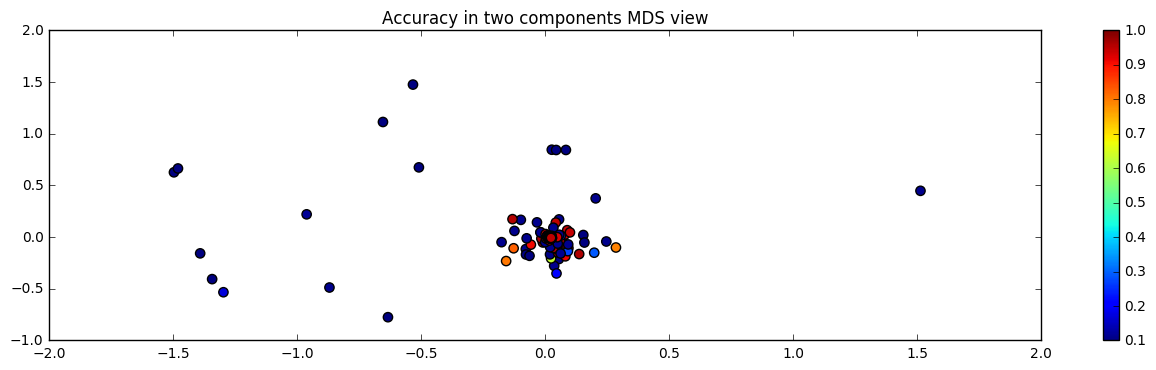

In [7]:
varMads = []
for p in mads:
    noeuds = p["noeuds"] + [0]*(3 - p["n_couches"])
    varMads.append([p["decay"], p["learning_rate"],
                    p["moment"], p["reg_l1"], p["reg_l2"],
                    noeuds[0], noeuds[1], noeuds[2]])
varMads = np.array(varMads)

plots.mds_accuracy(varMads / [1,1,1,1,1,500, 500, 500], accMads)

The function to optimize has a difficult structure to study and MADS fails to find new solutions. 
A good example of this is that only 22 training points have stricltly more than 1 neurons on the third layer.

To improve performance, we could make use of suroggate functions. Namely, a function that behave the same way as the original function but do not necessary approximate it. Such a function could be obptained by reducing the max number of epoch for instance.

## 5. hyperBayes: Bayesian optimisation

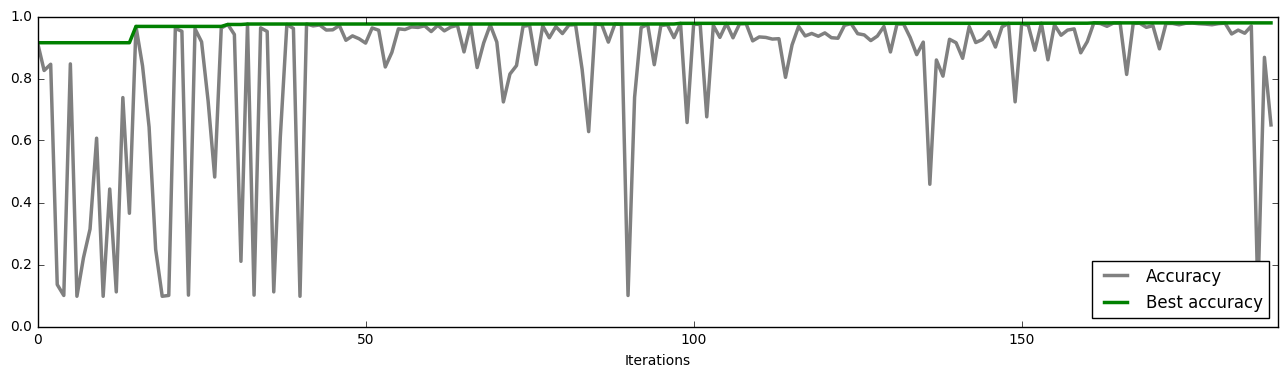

In [8]:
accBayes = np.array(map(lambda j: j["Accuracy"],
                        json.load(open("results/hyperBayes3.json", "r"))))
plots.accuracy(accBayes)

In [9]:
accBayes.max()

0.97940000000000005

## 6. Joint appoarch

## Reference and acknowledgements

Our experimentation would not be possible without the use of these great tools:
* <span id="1">[1]</span> __[Theano](https://github.com/Theano/Theano)__ Symbolic calculation library
* <span id="2">[2]</span> __[TensorFlow](https://www.tensorflow.org)__ Tensor manipulation
* <span id="3">[3]</span> __[Keras](https://github.com/fchollet/keras)__ Deep learning library
* <span id="4">[4]</span> __[NOMAD](https://www.gerad.ca/nomad/Project/Home.html)__ and __[OPAL](http://pythonoptimizers.github.io/opal/)__ Software for black box optimiaztion
* <span id="5">[5]</span> __[Spearmint](https://github.com/HIPS/Spearmint)__ Software to perform bayesian optimization

#### References
<span id="6">[6]</span> LeCun, Y., Cortes, C., & Burges, C. J. (1998). The MNIST database of handwritten digits.

<span id="7">[7]</span> Audet, C., & Dennis Jr, J. E. (2006). Mesh adaptive direct search algorithms for constrained optimization. SIAM Journal on optimization, 17(1), 188-217.

<span id="8">[8]</span> Audet, C., Dang, C. K., & Orban, D. (2011). Algorithmic parameter optimization of the DFO method with the OPAL framework. In Software Automatic Tuning (pp. 255-274). Springer New York.

<span id="9">[9]</span> Smithson, S. C., Yang, G., Gross, W. J., & Meyer, B. H. (2016). Neural networks designing neural networks: multi-objective hyper-parameter optimization. arXiv preprint arXiv:1611.02120.

<span id="10">[10]</span> Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical bayesian optimization of machine learning algorithms. In Advances in neural information processing systems (pp. 2951-2959).

<span id="11">[11]</span> Snoek, J., Rippel, O., Swersky, K., Kiros, R., Satish, N., Sundaram, N., ... & Adams, R. P. (2015, February). Scalable Bayesian Optimization Using Deep Neural Networks. In ICML (pp. 2171-2180).